Compare run-time for sparse update (gather,scatter as in PyG) vs dense update (fully connected graph, then mask out the non-edge). use a simplified GAT model

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch_scatter import scatter
import time
import matplotlib.pylab as plt

In [2]:
def sparse2dense(edge_index,v):
    # edge_index_dense has dimention (target, source)
    edge_index_dense = torch.zeros((v,v),dtype=torch.float32,device=device)
    for i in range(edge_index.shape[1]):
        edge_index_dense[edge_index[1,i],edge_index[0,i]] = 1.0
    return edge_index_dense

class GAT(torch.nn.Module):
    # no linear_proj as it is the same for sparse vs dense
    
    def __init__(self,d,v):
        super().__init__()
        self.v = v
        self.scoring_target = nn.Linear(d,1)
        self.scoring_source = nn.Linear(d,1)
    
    def forward(self,x,edge_index,IsSparse):
        scores_source = self.scoring_source(x)
        scores_target = self.scoring_target(x)
        if IsSparse:
            scores_source = scores_source.index_select(0, edge_index[0])
            scores_target = scores_target.index_select(0, edge_index[1])
            x_per_edge = x.index_select(0, edge_index[0])
            
            scores_per_edge = scores_source + scores_target # E
            scores_per_edge = scores_per_edge - scores_per_edge.max()
            scores_per_edge = scores_per_edge.exp()
            scores_sum = scatter(scores_per_edge,edge_index[1],0,reduce='sum',dim_size=self.v) # V
            scores_per_edge = scores_per_edge/(scores_sum.index_select(0, edge_index[1]) + 1e-16) # E
            
            x_per_edge = x_per_edge * scores_per_edge
            x = scatter(x_per_edge,edge_index[1],0,reduce='sum',dim_size=self.v)
            return x
        else:
            # edge_index expected should be in the form of adjacency matrix (target,source), 
            # edge has value 1 and non-edge has value 0
            scores = scores_target + scores_source.squeeze(1) # V,1 * 1,V' -> V,V' 
            scores = scores - scores.max(1,keepdim=True)[0]
            scores = edge_index * scores.exp() # mask out non-edge
            scores = scores/(scores.sum(1,keepdim=True) + 1e-16)
            x = torch.matmul(scores,x)
            return x

In [3]:
v = 5  # node
d = 30 # node feature
sparsity = 0.2
device = 'cuda'

In [4]:
edge_index_sparse = torch.Tensor(np.random.choice(v,(2,int(v*v*sparsity)))).long().to(device)
edge_index_dense = sparse2dense(edge_index_sparse,v)
# "requires_grad=True" to minic backward pass in training
x = torch.rand(v,d,dtype=torch.float32,requires_grad=True,device=device)

Check sparse and dense update give the same results. In my experiment, when v is large (100), there are some numerical issue, the max difference between the two implementation is kind of large. 

In [5]:
gat = GAT(d,v).to(device)
out = gat(x,edge_index_dense,False)
out2 = gat(x,edge_index_sparse,True)
(out-out2).abs().max()

tensor(5.9605e-08, device='cuda:0', grad_fn=<MaxBackward1>)

In [10]:
def timer(v,d,sparsity,repeats=20):
    edge_index_sparse = torch.Tensor(np.random.choice(v,(2,int(v*v*sparsity)))).long().to(device)
    edge_index_dense = sparse2dense(edge_index_sparse,v)
    x = torch.rand(v,d,dtype=torch.float32,requires_grad=True,device=device)
    gat = GAT(d,v).to(device)
    
    
    # dense
    t1 = time.time()
    for _ in range(repeats):
        gat(x,edge_index_dense,False).mean().backward() # fake objective just to run forward and backward path
    t2 = time.time()
    dense_time = t2 - t1
    
    # sparse
    t1 = time.time()
    for _ in range(repeats):
        gat(x,edge_index_sparse,True).mean().backward() # fake objective just to run forward and backward path
    t2 = time.time()
    sparse_time = t2 - t1   
    return sparse_time-dense_time

Try a few different setup for v,d. I was expecting to see sparse_time-dense_time to increase as sparsity increases, i.e. as graph gets dense, sparse update will take longer compared to dense. but this is not always the case.. I suspect this is due to overhead for those functions when v,d are small

In [9]:
out = np.array([(0.01+i/10,timer(1000,40,0.01+i/10)) for i in range(10)])

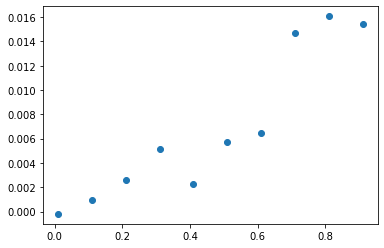

In [10]:
plt.scatter(out[:,0],out[:,1])

In [11]:
out = np.array([(0.01+i/10,timer(100,100,0.01+i/10)) for i in range(10)])

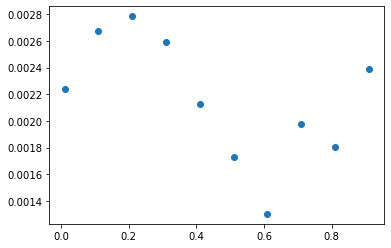

In [12]:
plt.scatter(out[:,0],out[:,1])

In [13]:
out = np.array([(0.01+i/10,timer(1000,100,0.01+i/10,1)) for i in range(10)])

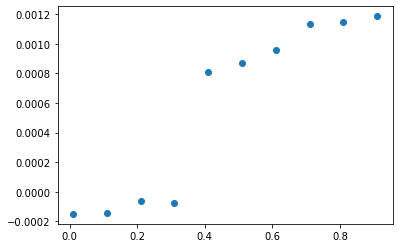

In [14]:
plt.scatter(out[:,0],out[:,1])

In [9]:
out = np.array([(0.01+i/10,timer(1000,200,0.01+i/10,1)) for i in range(10)])

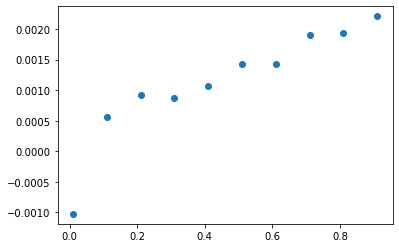

In [10]:
plt.scatter(out[:,0],out[:,1])

In [9]:
out = np.array([(0.01+i/10,timer(2000,100,0.01+i/10,1)) for i in range(6)])

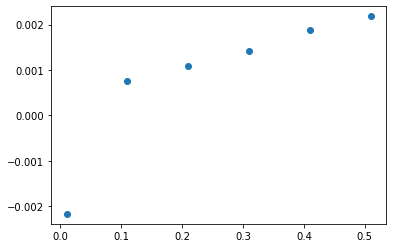

In [10]:
plt.scatter(out[:,0],out[:,1])

In [11]:
out = np.array([(i,timer(1000,200,i)) for i in np.linspace(0.005,0.1,8)])

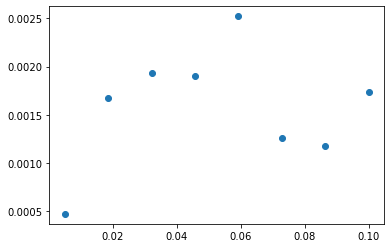

In [12]:
plt.scatter(out[:,0],out[:,1])